# Question-oriented User Exploration
Deep dive into the Mojo's user-related questions and bring as much insights as possible 
Question reference: https://docs.google.com/spreadsheets/d/1U3swTSQ-a8HAKBHeB4dpRx4JrxNchUASkCBwlW9DDY8/edit#gid=7214629


### load python packages, custom-defined functions and set up environment

In [211]:
# load all the packages
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
import os.path
from subscription_donation_preprocess import *
from user_exploration_functions import *
from matplotlib.pyplot import plot
 
# to show the whole content in the columns
pd.set_option('display.max_colwidth', -1)

## load and aggregate data


- load subscription and donation data separately.
- group by email and calculate the frequency, recency, date range and money value of subscriptions and donations
- combine processed subscription and donation data
- Then load pre-processed click data
- group by email and count the unique number of urls and topics the email clicked.
- combine processed subscription and donation data with the aggregated click data to a single wide data frame.


In [2]:
subsciption_filename = '/home/centos/mojo/data/subscriptions.xlsx'
donation_filename = '/home/centos/mojo/data/donations_combined.xlsx'
sub_don_combined_filename = '/home/centos/mojo/subscription_donation_processed_data.pkl'
click_data_filename = '/home/centos/mojo/newsletter_processed_data.pkl'
sub_don_click_combined_filename = '/home/centos/mojo/subscription_donation_click_combined_data.pkl'

# load data if its pickle exists otherwise reprocess the data
if os.path.exists(sub_don_combined_filename):
    combined = pd.read_pickle(sub_don_combined_filename)
    subscription = pd.read_excel(subsciption_filename)
    donation = pd.read_excel(donation_filename)
    print('load the combined processed subscription and donation data as data frame combined')
else:
    subscription, donation, combined = sub_don_process(subsciption_filename,
                                                       donation_filename )

    combined.to_pickle(sub_don_combined_filename)
    

# created by https://github.com/datakind/mj_user_engagement/blob/tingting/newsletter_clicks_parser/mojo_newsletter_clicks_preprocess.py
click_data = pd.read_pickle(click_data_filename)

if os.path.exists(sub_don_click_combined_filename):
    sub_don_click_combined = pd.read_pickle(sub_don_click_combined_filename)
    print('load the combined processed subscription, donation and click data as data frame sub_don_click_combined')

else:    
    nclicks_by_users = click_data.groupby('Email').agg({'Url': pd.Series.nunique,'topic':pd.Series.nunique})
    nclicks_by_users = nclicks_by_users.reset_index()

    nclicks_by_topics = reshape_data_to_wide(click_data,
                                             row = 'Email', 
                                             col = 'topic', 
                                             element = 'Url',
                                             cal = 'sum')
    nclicks_by_topics = nclicks_by_topics.reset_index()
    nclicks_by_topics = nclicks_by_topics.rename(columns = {'':'NA'})

    sub_don_click_combined_temp = combine_dat_sets(combined, 
                                                   nclicks_by_users, 
                                                   'Email','Email', join_method = 'left')
    sub_don_click_combined = combine_dat_sets(sub_don_click_combined_temp, 
                                              nclicks_by_topics, 
                                              'Email','Email', join_method = 'left')
    sub_don_click_combined = sub_don_click_combined.set_index('Email')

    sub_don_click_combined.to_pickle(sub_don_click_combined_filename)

load the combined processed subscription and donation data as data frame combined
load the combined processed subscription, donation and click data as data frame sub_don_click_combined


### The final product of the aggregation process:
data frame 'sub_don_click_combined' with Email as index and columns explained as blow:


|Email| email|
| --- | --- | 
|subs_total|total dollar paid for subscription|
|subs_freq| # subscriptions|
|subs_recency| # days since the latest subscription|
|subs_range| # days between the first and the last subscriptions|
|don_total|total dollar paid for donation|
|don_freq|donations|
|don_recency| # days since the latest donation|
|don_range|# days between the first and the last subscriptions|
|MJM| if the email has pub code MJM |
|DON| if the email has pub code DON |
|SDN| if the email has pub code SDN (recurring donor) |
|topic|	# unique topic the email clicked |
|Url| # unique urls the email clicked | 
|NA| # urls the email clicked for topic 'NA' |	
|about|	# urls the email clicked for topic 'about' |
|crime-justice|	# urls the email clicked for topic 'crime-justice' |
|environment| # urls the email clicked for topic 'environment' |
|food| # urls the email clicked for topic 'food' |
|media|	# urls the email clicked for topic 'media' |
|politics|	# urls the email clicked for topic 'politics' |
|topics|# urls the email clicked for topic 'topics' |	
|All| # urls the email clicked for all the topics |

In [3]:
sub_don_click_combined.head()

,subs_total,subs_freq,subs_recency,subs_range,don_total,don_freq,don_recency,don_range,MJM,DON,...,topic,NA,about,crime-justice,environment,food,media,politics,topics,All
Email,,,,,,,,,,,,,,,,,,,,,
00005cfbddbc503ae8837036a9b96cec672997922271a736c2253c88108a9c937c65648e3e7232ba8bbc4cab14fef463e94a1acb2287de698d1790af58c4d8d3,22.0,1.0,261.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
0000a8d23211fec8ed10561725547e244648f4dfd391c7d7262d324eac5a15c805d18b21c03df78da876048a1a7d9954c62535a678296c16b75432944d51e167,36.0,2.0,39.0,380.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00020b15c1f68335def0ad9595c3c4924988436ef3c6a07f4777cd31e9cd9fc3f0db62e389c469210098fee366e1aee1e7533828ec5c43d3bba3ffabd5a2eb47,10.0,1.0,137.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0005315e482a03c153ba6c1d9bb706f932dba8036634a9edc75fe917222e024f3a456236162769958889024a115eac631eccb72d104ffd1b59799949cb1a2761,28.0,1.0,140.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00053a35d9cf185fa51e183311a50da24d0cc5d34f2608b74cd3b7bae2d6a01e9746715defd6827804faca1e36ed7cbd85e1f248f2a69a453d843cc3550f7d57,36.0,2.0,40.0,379.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## basic summary of the data


In [4]:
subscription_counts = basic_counts(subscription)
donation_counts = basic_counts(donation)

### subscription data basic counts summary

In [5]:
print('### SUBSCRIPTION ###')
print("Data date ranges from {} to {}".format(subscription_counts['min_date'].date(),subscription_counts['max_date'].date()))
print("count of unique emails: {}".format(str(subscription_counts['nemails'])))
print("count of unique emails by pub code:") 
display(subscription_counts['nemails_by_pub'])

print('count of overlap between pub codes: {}'.format(subscription_counts['noverlap']))



### SUBSCRIPTION ###
Data date ranges from 2017-10-01 to 2018-11-09
count of unique emails: 51177
count of unique emails by pub code:


,EMAIL
ORD-PUB-CODE,
MJM,51177


count of overlap between pub codes: 0


### subscription payment distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2449f9e48>]],
      dtype=object)

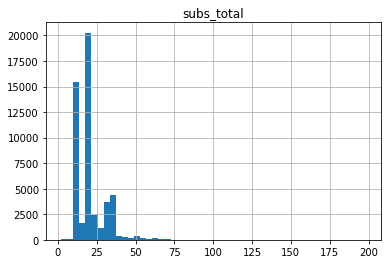

In [6]:
combined[(combined['subs_freq'] > 0) & (combined['subs_total'] < 200)].hist(column = 'subs_total',bins = 50)

### donation data basic counts summary

In [7]:
print('### DONATION ###')
print("Data date ranges from {} to {}".format(donation_counts['min_date'].date(),donation_counts['max_date'].date()))
print("count of unique emails: {}".format(str(donation_counts['nemails'])))
print("count of unique emails by pub code:") 
display(donation_counts['nemails_by_pub'])
print(donation_counts['nemails_by_pub']/donation_counts['nemails'])
print('\n')
print('count of emails having both DON and SDN: {}'.format(donation_counts['noverlap']))
print('%{} donoars have both DON and SDN'. format(round(donation_counts['noverlap']/donation_counts['nemails']*100,2)))

### DONATION ###
Data date ranges from 2017-10-01 to 2018-11-09
count of unique emails: 36473
count of unique emails by pub code:


,EMAIL
ORD-PUB-CODE,
DON,30435
SDN,7059


                 EMAIL
ORD-PUB-CODE          
DON           0.834453
SDN           0.193540


count of emails having both DON and SDN: 1021
%2.8 donoars have both DON and SDN


### aggregates email counts by donation amount per person

In [9]:
cnts = combined[(combined['don_freq'] > 0)].groupby('don_total').agg({'Email': 'count'})
cnts = cnts.reset_index()
cnts['Email_cumpct'] = (cnts['Email']/cnts['Email'].sum()).cumsum()
cnts['don_total_cumpct'] = cnts['don_total'].cumsum()/cnts['don_total'].sum()
cnts.head()

,don_total,Email
0,0.01,1
1,0.05,2
2,0.20,1
3,0.48,1
4,1.00,73


### histogram of all the donations

Text(0,0.5,'counts')

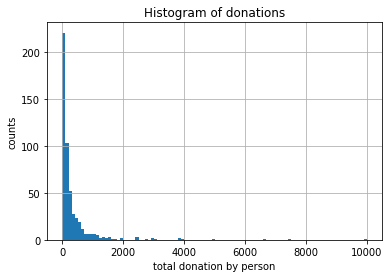

In [10]:
import pylab as pl
cnts_hist = cnts.hist(column = 'don_total', bins = 100)
pl.title("Histogram of donations")
pl.xlabel("total donation by person")
pl.ylabel("counts")

### histogram of donations below $1000

Text(0,0.5,'counts')

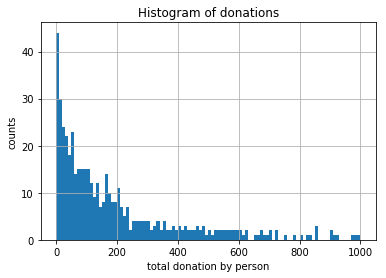

In [15]:
import pylab as pl
cnts_hist = cnts.hist(column = 'don_total', bins = 100, range = [0,1000])
pl.title("Histogram of donations")
pl.xlabel("total donation by person")
pl.ylabel("counts")

### analyze the relationship between cumulative donation and cumulative email freq

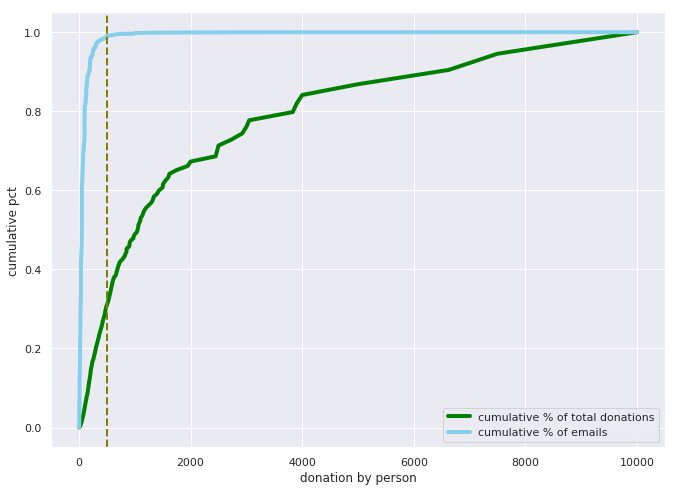

In [224]:
import matplotlib.pyplot as plt
plt.plot( 'don_total', 'don_total_cumpct', data=cnts, marker='', markerfacecolor='green', markersize=12, color='green', linewidth=4)
plt.plot( 'don_total', 'Email_cumpct',data=cnts, marker='', color='skyblue', linewidth=4)
plt.legend(labels = ['cumulative % of total donations','cumulative % of emails'])
plt.grid(True)
pl.title("")
pl.xlabel("donation by person")
pl.ylabel("cumulative pct")

plt.axvline(x=500, linestyle = '--',color='olive', linewidth=2)
#plt.axhline(y=cnts['Email_cumpct'][cnts['don_total']==300].unique(), linestyle = '-')

### analyze the relationship between cumulative donation and cumulative email freq for donation below $1000

426    0.990815
Name: Email_cumpct, dtype: float64
426    0.308898
Name: don_total_cumpct, dtype: float64


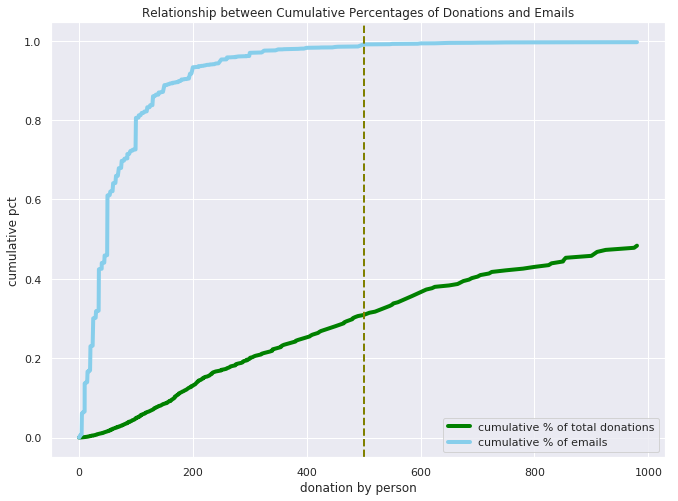

In [226]:
import seaborn as sns; 
sns.set()
import matplotlib.pyplot as plt
plt.plot( 'don_total', 'don_total_cumpct', data=cnts[cnts['don_total'] < 1000], marker='', markerfacecolor='green', markersize=12, color='green', linewidth=4)
plt.plot( 'don_total', 'Email_cumpct',data=cnts[cnts['don_total'] < 1000], marker='', color='skyblue', linewidth=4)
plt.legend(labels = ['cumulative % of total donations','cumulative % of emails'])
plt.grid(True)
pl.title("Relationship between Cumulative Percentages of Donations and Emails")
pl.xlabel("donation by person")
pl.ylabel("cumulative pct")

plt.axvline(x=500, linestyle = '--',color='olive', linewidth=2)
print(cnts['Email_cumpct'][cnts['don_total']==500])
print(cnts['don_total_cumpct'][cnts['don_total']==500])

## Q1. Which donors are also subscribers and vice versa?

### create confusion matrix between donors and subscribers and find overlap

In [20]:
combined_cf = pd.crosstab(combined['subs_freq'].astype('bool'), 
                          combined['don_freq'].astype('bool'), 
                          rownames=['subscription'], 
                          colnames=['donation'], margins=True)
print('confusion matrix of magazine subscription and donation')
print('\n')
print(combined_cf)
print('\n')
print('{}% of magazine subscribers also donated'.format(round(100*combined_cf.iloc[1,1]/combined_cf.iloc[1,2])))
print('{}% of donors are magazine subscribers'.format(round(100*combined_cf.iloc[1,1]/combined_cf.iloc[2,1])))

don_clicked_url = sum((sub_don_click_combined['don_freq'] > 0) & (sub_don_click_combined['Url']>0))
total_donor = sum(sub_don_click_combined['don_freq'] > 0)

print('Also, {} donors clicked Oct newsletter ({}%)'.format(don_clicked_url,round(don_clicked_url/total_donor*100,2)))
    

confusion matrix of magazine subscription and donation


donation      False   True    All
subscription                     
False         0      27326  27326
True          42030  9147   51177
All           42030  36473  78503


18.0% of magazine subscribers also donated
25.0% of donors are magazine subscribers
Also, 5410 donors clicked Oct newsletter (14.83%)


### If people both donated and subcribed, did they donate first or subscribe first? How many days between the two actions?

In [51]:
both_donor_sub = sub_don_click_combined[(sub_don_click_combined['subs_freq'] > 0) & (sub_don_click_combined['don_freq'] > 0)]
both_donor_sub['earliest_don'] = both_donor_sub['don_range'] +  both_donor_sub['don_recency']
both_donor_sub['earliest_sub'] = both_donor_sub['subs_range'] +  both_donor_sub['subs_recency']
both_donor_sub = both_donor_sub[['earliest_don','earliest_sub']]
both_donor_sub = both_donor_sub.reset_index()

/home/centos/mojo/mojoenv/lib/python3.4/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/centos/mojo/mojoenv/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
def transition_type(earliest_don, earliest_sub):
    if earliest_don > earliest_sub:
        return 'Donate first'
    if earliest_don < earliest_sub:
        return 'Subscribe first'
    if earliest_don == earliest_sub:
        return 'Donate and subscribe on the same day'
  

    

both_donor_sub['transition_type'] = both_donor_sub.apply(lambda x: transition_type(x[1],x[2]), axis=1)
both_donor_sub['transition_period'] = abs(both_donor_sub['earliest_don'] - both_donor_sub['earliest_sub'])
both_donor_sub_transition = both_donor_sub.groupby('transition_type').agg({'Email':'count','transition_period':'median'})
both_donor_sub_transition = both_donor_sub_transition.rename(columns = {'Email': 'email count',
                                             'transition_period': 'average days between transition'})
both_donor_sub_transition['email pct (%)'] = round(both_donor_sub_transition['email count']/both_donor_sub_transition['email count'].sum()*100,2)
both_donor_sub_transition[['email pct (%)','average days between transition']]

,email pct (%),average days between transition
transition_type,,
Donate and subscribe on the same day,24.87,0.0
Donate first,42.53,57.0
Subscribe first,32.60,72.0


### average donation from subscriber donors vs non-subscriber donors 

In [96]:
sub_don_avg = combined[(combined['don_freq'] > 0) & (combined['subs_freq'] > 0)]['don_total'].median()
nonsub_don_avg = combined[(combined['don_freq'] > 0) & (combined['subs_freq'] == 0)]['don_total'].median()
pct_high_sub_don = round(100*(combined[(combined['don_freq'] > 0) & (combined['subs_freq'] > 0)]['don_total'] > 300).mean(),2)
pct_high_nonsub_don = round(100*(combined[(combined['don_freq'] > 0) & (combined['subs_freq'] == 0)]['don_total'] > 300).mean(),2)

print('subscriber donors donated ${} on average'.format(sub_don_avg))
print('{}% subscriber donors donated over $300'.format(pct_high_sub_don))
print('non-subscriber donors donated ${} on average'.format(nonsub_don_avg))
print('{}% non-subscriber donors donated over $300'.format(pct_high_nonsub_don))

subscriber donors donated $50.0 on average
2.58% subscriber donors donated over $300
non-subscriber donors donated $50.0 on average
3.19% non-subscriber donors donated over $300


## Q2. What kinds of leads generate the most high-value donors?

Not answerable 

Henry's Note:
Ask MJ what they mean by the "kinds" of leads.

Adam will provide fundraising emails that may be a way for us to tackle this.  They may have some data about the leads, the types of fundraising email, and what in the email the lead engaged with.

Adam will also follow up internally to better define what features they would be interested in exploring when they say "kind of leads", and see if there are data sources to get a handle on that.

### some insights into high-value donors

### data prep: dive donors into multiple groups
- regular donors (< 500 dollars)
- highvalue donors (>= 500 dollars)
- SDN donors
- one-time big time donor
- multi-time non SDN donors
- non donors
- all donors

In [17]:
# create a dictionary with different donor groups
donor_groups = define_donor_groups(df = sub_don_click_combined)

for i in donor_groups.keys():
    print(i)

regular donors (< $500)
highvalue donors (>= $500)
SDN donors
one-time big time donor
multi-time non SDN donors
non donors
all donors


### a. How many are high-value donors? How much are their donations? Are they one-time big check donor or frequent small amount donors

In [18]:
n_high_value_donors = donor_groups['highvalue donors (>= $500)'].shape[0]
n_total_donors = combined.loc[combined['don_total'] > 0].shape[0]
total_donation = round(sum(donor_groups['all donors']['don_total']))
total_highvalue_donation = round(sum(donor_groups['highvalue donors (>= $500)']['don_total']))

print('number of high-value donors:{}'.format(n_high_value_donors))
print('{}% of donnars are high-value donors'.format(round(100*n_high_value_donors/n_total_donors,2)))
print('total donation:${}'.format(total_donation))
print('total donation from high-value donors: ${} ({}%)'.
     format(total_highvalue_donation,
            round(total_highvalue_donation/total_donation*100, 2)))


number of high-value donors:526
1.44% of donnars are high-value donors
total donation:$2949751
total donation from high-value donors: $453636 (15.38%)


In [19]:
n_SDN_highdonors = donor_groups['SDN donors'].shape[0]
total_SDN_donation = round(sum(donor_groups['SDN donors']['don_total']))

n_onetime_DON_highdonors = donor_groups['one-time big time donor'].shape[0]
total_onetime_DON_donation = round(sum(donor_groups['one-time big time donor']['don_total']))

n_multitime_DON_highdonors = donor_groups['multi-time non SDN donors'].shape[0]
total_multitime_DON_donation = round(sum(donor_groups['multi-time non SDN donors']['don_total']))


print('number of SDN: {}; donated ${}'.format(n_SDN_highdonors,total_SDN_donation))


print('number of one time donors: {}; donated ${}'.format(n_onetime_DON_highdonors,total_onetime_DON_donation))


print('number of multi-time non SDN donors: {}; donated ${}'.format(n_multitime_DON_highdonors,total_multitime_DON_donation))


number of SDN: 156; donated $134091
number of one time donors: 226; donated $207046
number of multi-time non SDN donors: 144; donated $112498


### b. are high-value donors also magazine subscribers or newsletter subuscribers? what are their interested topics?

In [20]:
# use OrderedDict to keep results in certain order
donor_groups_summary = []

for grpname, dat in donor_groups.items():
    
    donor_groups_summary.append(check_subscription_rate(df =dat, groupname =grpname))
    

donor_groups_summary_df = pd.DataFrame.from_records(donor_groups_summary)
donor_groups_summary_df = donor_groups_summary_df.rename(columns = {0:'donor groupname',
                                                                    1: 'magazine subscription rate',
                                                                    2: 'newsletter click rate'})

print("compare magazine subscription rate and newsletter click rate by each donor group ")   
donor_groups_summary_df

compare magazine subscription rate and newsletter click rate by each donor group 


,donor groupname,magazine subscription rate,newsletter click rate
0,regular donors (< $500),25.12,14.78
1,highvalue donors (>= $500),22.24,18.44
2,SDN donors,15.38,26.28
3,one-time big time donor,22.57,10.62
4,multi-time non SDN donors,29.17,22.22
5,non donors,100.00,6.40
6,all donors,25.08,14.83


In [21]:
donor_groups_click_summary = []

for grpname, dat in donor_groups.items():
    
    donor_groups_click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by each donor group ")    
pd.concat(donor_groups_click_summary, axis=1)


compare # urls clicked by each donor group 


,regular donors (< $500),highvalue donors (>= $500),SDN donors,one-time big time donor,multi-time non SDN donors,non donors,all donors
count,5313.00,97.00,41.00,24.00,32.00,2692.00,5410.00
mean,6.45,7.02,7.17,4.04,9.06,4.66,6.46
std,10.00,8.70,8.45,3.93,10.92,8.52,9.97
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,2.00,2.00,1.00,2.00,1.00,2.00
50%,3.00,4.00,4.00,3.50,4.50,2.00,3.00
75%,8.00,8.00,9.00,5.00,9.00,5.00,8.00
max,238.00,42.00,42.00,18.00,41.00,242.00,238.00


In [30]:
topics = ['about','crime-justice','environment','food','media','politics','topics']
comparison_groups = ['highvalue donors (>= $500)','regular donors (< $500)','non donors']
combo = pd.concat([sub_df_colsum(df = donor_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(donor_groups[g]['All'])*100,2) 
     
        

print('compare none donors (people never donated), regular donors and high-value donors of the topics they clicked')
print('all the numbers are the percentage of urls containing the certain topics')

combo

compare none donors (people never donated), regular donors and high-value donors of the topics they clicked
all the numbers are the percentage of urls containing the certain topics


,highvalue donors (>= $500),regular donors (< $500),non donors
about,0.00,0.01,0.02
crime-justice,0.44,0.30,0.31
environment,21.00,19.05,18.63
food,6.75,6.11,6.56
media,3.52,2.89,2.32
politics,56.39,59.50,58.98
topics,0.00,0.08,0.10


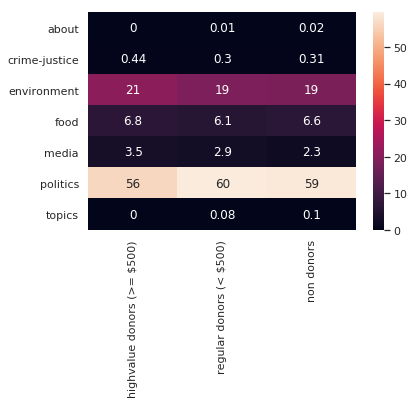

In [32]:
# heat of the table above
import seaborn as sns; sns.set()
sns.heatmap(combo, annot=True)

In [33]:
# donors from the month
min_date = datetime.date(2018, 9, 19)
max_date = datetime.date(2018, 10, 30)
oct_donors = donation[(donation['ORD ENTR DT'] > min_date) & (donation['ORD ENTR DT'] < max_date)]['EMAIL'].unique().tolist()


donor_groups['campaign_highvalue_donors'] = sub_don_click_combined.loc[(sub_don_click_combined['don_total'] >= 500) & sub_don_click_combined.index.isin(oct_donors) ]
donor_groups['campaign_regular_donors'] = sub_don_click_combined.loc[(sub_don_click_combined['don_total'] > 0) & (sub_don_click_combined['don_total'] < 500)& sub_don_click_combined.index.isin(oct_donors) ]


In [35]:
topics = ['about','crime-justice','environment','food','media','politics','topics']
comparison_groups = ['non donors',
                     'regular donors (< $500)',
                     'highvalue donors (>= $500)',
                     'campaign_regular_donors',
                     'campaign_highvalue_donors'
                    ]
combo = pd.concat([sub_df_colsum(df = donor_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(donor_groups[g]['All'])*100,2) 
     

print('compare none donors (people never donated), regular donors and high-value donors of the topics they clicked')
print('all the numbers are the percentage of urls containing the certain topics')

combo

compare none donors (people never donated), regular donors and high-value donors of the topics they clicked
all the numbers are the percentage of urls containing the certain topics


,non donors,regular donors (< $500),highvalue donors (>= $500),campaign_regular_donors,campaign_highvalue_donors
about,0.02,0.01,0.00,0.00,0.00
crime-justice,0.31,0.30,0.44,0.27,0.30
environment,18.63,19.05,21.00,18.68,21.43
food,6.56,6.11,6.75,5.91,6.85
media,2.32,2.89,3.52,2.90,4.76
politics,58.98,59.50,56.39,59.84,55.95
topics,0.10,0.08,0.00,0.07,0.00


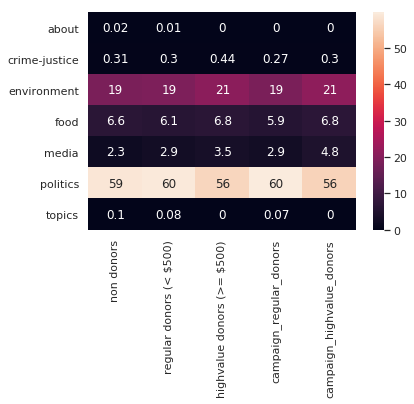

In [36]:
sns.heatmap(combo, annot=True)

## Q3. How long do newsletter subscribers tend to stay subscribed?

Not answerable 

In this question subsribers means subscribers to the newsletter, not the magazine.  We actually don't have data for people unsubscribing to the newsletter, but a more interesting measure is to instead ask when people stop engaging with the newsletter.  E.g. when do we see a dropoff in clicking (in their emails appearing in the emails campaign data).

## Q4. What do our print subscribers engage in vs our online readers in the newsletters?

The newsletter click data ranges from 2018/09/19 to 2018/10/30
The magazine subscription data ranges from 2017-10-01 to 2018-11-09

Limit magazine subscribers to 2017/09/20 - 2018/10/30 to get the overlap between newsletter subscribes and magazine subscribes

In [46]:
# check if `nclicks_by_users` and `nclicks_by_topics` have been defined in cell 2
if 'nclicks_by_users' not in locals():
    nclicks_by_users = click_data.groupby('Email').agg({'Url': pd.Series.nunique,'topic':pd.Series.nunique})
    nclicks_by_users = nclicks_by_users.reset_index()

    nclicks_by_topics = reshape_data_to_wide(click_data,
                                             row = 'Email', 
                                             col = 'topic', 
                                             element = 'Url',
                                             cal = 'sum')
    nclicks_by_topics = nclicks_by_topics.reset_index()
    nclicks_by_topics = nclicks_by_topics.rename(columns = {'':'NA'})
else:
    pass

In [89]:
min_date = datetime.date(2017, 9, 20)
min_date2 = datetime.date(2018, 9, 19)
max_date = datetime.date(2018, 10, 30)

# get all the emails who subscribed the magazine within a year of the click data but before the end date of the click data
mag_sub = subscription[(subscription['ORD ENTR DT'] > min_date) & (subscription['ORD ENTR DT'] < max_date)]['EMAIL'].unique().tolist()
# get all the emails who subscribed the magazine during the newsletter campaign
ecent_mag_sub = subscription[(subscription['ORD ENTR DT'] > min_date2) & (subscription['ORD ENTR DT'] < max_date)]['EMAIL'].unique().tolist()
# get all the emails who subscribed the news letter
news_sub = click_data['Email'].unique().tolist()

mag_news_sub_all = combine_dat_sets(nclicks_by_topics, nclicks_by_users, 'Email','Email', join_method = 'left')
mag_news_sub_all['MJM'] = mag_news_sub_all['Email'].isin(mag_sub)

online_reader_groups=OrderedDict()
online_reader_groups['magazine subscribers']=mag_news_sub_all[mag_news_sub_all['MJM'] == True]
online_reader_groups['non-magazine subscribers']=mag_news_sub_all[ mag_news_sub_all['MJM'] == False]
online_reader_groups['recent magazine subscribers']=mag_news_sub_all[(mag_news_sub_all['MJM'] == True) & (mag_news_sub_all['Email'].isin(recent_mag_sub))]

### a. how many online readers have subscribed the magazine?

In [90]:
print('out of {} clicked the newsletter, {} have subscribed magazine within a year ({}%)'.format(
    mag_news_sub_all.shape[0], 
    sum(mag_news_sub_all['MJM']), 
    round(sum(mag_news_sub_all['MJM'])/mag_news_sub_all.shape[0]*100,2)
 ))


out of 55240 clicked the newsletter, 4104 have subscribed magazine within a year (7.43%)


### b. what's the click rate difference between online reasers who subcribed the magazines within a year,  who subscribed the magazines during the newsletter campaign and who didn't subcribe the magazines?

In [92]:
online_reader_groups_click_summary = []

for grpname, dat in online_reader_groups.items():
    
    online_reader_groups_click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by each donor group ")    
display(pd.concat(online_reader_groups_click_summary, axis=1))

online_reader_groups_topics_summary = []

for grpname, dat in online_reader_groups.items():
    
    online_reader_groups_topics_summary.append(check_topics_distribution(df =dat, groupname =grpname))
    
print("compare # topics clicked by each donor group ")    
display(pd.concat(online_reader_groups_topics_summary, axis=1))

compare # urls clicked by each donor group 


,magazine subscribers,non-magazine subscribers,recent magazine subscribers
count,4104.00,51135.00,577.00
mean,5.13,4.38,5.31
std,8.41,9.69,7.26
min,1.00,1.00,1.00
25%,1.00,1.00,1.00
50%,3.00,2.00,3.00
75%,6.00,4.00,6.00
max,242.00,296.00,78.00


compare # topics clicked by each donor group 


,magazine subscribers,non-magazine subscribers,recent magazine subscribers
count,4104.00,51135.00,577.00
mean,1.93,1.73,2.00
std,1.12,1.05,1.11
min,1.00,1.00,1.00
25%,1.00,1.00,1.00
50%,2.00,1.00,2.00
75%,3.00,2.00,3.00
max,8.00,8.00,5.00


### c. what's the difference in the interested topics between online reasers who subcribed the magazines within a year, who subscribed the magazines during the newsletter campaign and who didn't subcribe the magazines?

In [58]:
# compare topic click rate
topics = ['about','crime-justice','environment','food','media','politics','topics']
comparison_groups = ['magazine subscribers',
                     'non-magazine subscribers',
                     'recent magazine subscribers'
                    ]
combo = pd.concat([sub_df_colsum(df = online_reader_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(online_reader_groups[g]['All'])*100,2) 
     
print('compare magazine subscribers, recent magazine subscribers and non subscribers of the topics they clicked')
print('all the numbers are the percentage of urls containing the certain topics')
combo

compare magazine subscribers, recent magazine subscribers and non subscribers of the topics they clicked
all the numbers are the percentage of urls containing the certain topics


,magazine subscribers,non-magazine subscribers,recent magazine subscribers
about,0.01,0.10,0.00
crime-justice,0.29,0.26,0.26
environment,18.59,17.87,18.85
food,6.46,6.46,6.56
media,2.61,2.50,2.77
politics,59.41,58.74,59.72
topics,0.09,0.16,0.07


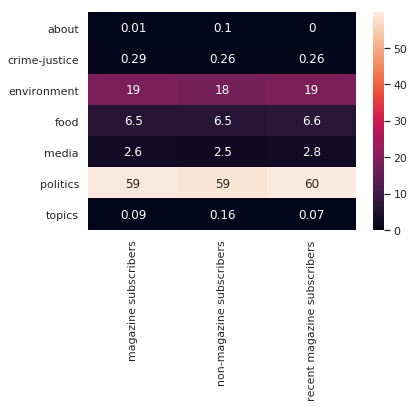

In [59]:
sns.heatmap(combo, annot=True)

### d. what's the difference in the most popular titles between online readers who subcribed the magazines within a year, who subscribed the magazines during the newsletter campaign and who didn't subcribe the magazines?

In [67]:
def find_most_popular_titles(df, emails, topN = 10):
    """an example of df is click_data from '/home/centos/mojo/newsletter_processed_data.pkl'"""
    temp_data = df.loc[df['Email'].isin(emails)]
    temp_data = temp_data[temp_data['title']!='']


    hoturls = temp_data.groupby('title').agg({'Email': pd.Series.nunique})
    hoturls = hoturls.reset_index()
    hoturls = hoturls.rename(columns = {'Email':'email_count'})
    hoturls['email_pct'] = round(hoturls['email_count']/len(temp_data['Email'].unique())*100,2)
    topN_urls = hoturls.sort_values(by='email_count', ascending=False).head(topN)
    
    return topN_urls

In [68]:
print("Top 10 clicks from online readers who subcribed the magazines within a year")
find_most_popular_titles(df = click_data, emails = online_reader_groups['magazine subscribers']['Email'])

Top 10 clicks from online readers who subcribed the magazines within a year


,title,email_count,email_pct
114,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,940,23.28
200,whale-videos-triple-breach-wow,690,17.09
70,garrett-ventry-resign-kavanaugh,576,14.27
168,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,572,14.17
95,jared-kushner-taxes-net-worth-real-estate-trump-investments,529,13.10
105,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,494,12.24
181,trump-christine-blasey-ford-kavanaugh,491,12.16
123,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,458,11.35
197,washington-carbon-ballot-i1631,446,11.05
28,brian-wansink-the-cornell-professor-known-for-his-fun-food-research-retires-amid-scandal-1,406,10.06


In [69]:
print("Top 10 clicks from online readers who didn't subcribe the magazines")
find_most_popular_titles(df = click_data, emails = online_reader_groups['non-magazine subscribers']['Email'])

Top 10 clicks from online readers who didn't subcribe the magazines


,title,email_count,email_pct
118,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,10255,20.53
207,whale-videos-triple-breach-wow,7303,14.62
71,garrett-ventry-resign-kavanaugh,6249,12.51
98,jared-kushner-taxes-net-worth-real-estate-trump-investments,5767,11.55
174,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,5661,11.33
187,trump-christine-blasey-ford-kavanaugh,5430,10.87
108,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,5254,10.52
127,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,4281,8.57
204,washington-carbon-ballot-i1631,4209,8.43
29,brian-wansink-the-cornell-professor-known-for-his-fun-food-research-retires-amid-scandal-1,4089,8.19


In [70]:
print("Top 10 clicks from online readers who subscribed the magazines during the newsletter campaign")
find_most_popular_titles(df = click_data, emails = online_reader_groups['recent magazine subscribers']['Email'])

Top 10 clicks from online readers who subscribed the magazines during the newsletter campaign


,title,email_count,email_pct
94,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,143,25.22
169,whale-videos-triple-breach-wow,88,15.52
141,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,82,14.46
79,jared-kushner-taxes-net-worth-real-estate-trump-investments,76,13.40
100,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,76,13.40
57,garrett-ventry-resign-kavanaugh,74,13.05
87,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,73,12.87
166,washington-carbon-ballot-i1631,69,12.17
6,a-new-study-shows-how-mushrooms-could-save-bees-yes-mushrooms,59,10.41
151,trump-christine-blasey-ford-kavanaugh,58,10.23


## Q5.  What differences and similarities can we find between loyal subscribers and new donors?

Assume: 
- loyal subscribers are people who subscribed magazines two years in a row (assume people renew within a month before the subscription expires)
- new donors are people who first donated during the campaigns.

### a.how many loyal subscribers and new donors clicked newsletter? how much did they donate?

In [73]:
loyal_sub = sub_don_click_combined[sub_don_click_combined['subs_range'] > 365-28]

# donors from the month
min_date = datetime.date(2018, 9, 19)
max_date = datetime.date(2018, 10, 30)
old_donors_emails = donation[donation['ORD ENTR DT'] < min_date]['EMAIL'].unique().tolist()
new_donors_emails = donation['EMAIL'][~donation['EMAIL'].isin(old_donors_emails)]

new_donors = sub_don_click_combined[sub_don_click_combined.index.isin(new_donors_emails)]

interested_groups=OrderedDict()
interested_groups['loyal subscribers'] = loyal_sub
interested_groups['new donors'] = new_donors

In [76]:
print("{} % loyal subscribers clicked and {}% donated ${} on average per person".format(
    round(100*((interested_groups['loyal subscribers']['Url'] > 0).mean()),2),
    round(100*((interested_groups['loyal subscribers']['don_freq'] > 0).mean()),2),
    round(interested_groups['loyal subscribers'][interested_groups['loyal subscribers']['don_freq'] > 0]['don_total'].mean(),2)))

7.34 % loyal subscribers clicked and 11.41% donated $94.49 on average per person


In [82]:
print("{} % new donors clicked and donated ${} on average per person".format(
    round(100*((interested_groups['new donors']['Url'] > 0).mean()),2),
    round(interested_groups['new donors']['don_total'].mean(),2)))

13.36 % new donors clicked and donated $31.42 on average per person


In [ ]:
## click rate comparison
## topic comparison
## topic article comparison

### b. compare the number of urls clicked by loyal subscribers and new donors 

In [88]:
interested_groups_click_summary = []

for grpname, dat in interested_groups.items():
    
    interested_groups_click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by loyal subscribers vs new donors ")    
display(pd.concat(interested_groups_click_summary, axis=1))

interested_groups_topics_summary = []

for grpname, dat in interested_groups.items():
    
    interested_groups_topics_summary.append(check_topics_distribution(df =dat, groupname =grpname))
    
print("compare # topics clicked by loyal subscribers vs new donors")    
display(pd.concat(interested_groups_topics_summary, axis=1))

compare # urls clicked by loyal subscribers vs new donors 


,loyal subscribers,new donors
count,321.00,583.00
mean,4.29,5.69
std,5.35,6.41
min,1.00,1.00
25%,1.00,2.00
50%,2.00,3.00
75%,5.00,7.00
max,37.00,51.00


compare # topics clicked by loyal subscribers vs new donors


,loyal subscribers,new donors
count,321.00,583.00
mean,1.78,2.11
std,1.03,1.16
min,1.00,1.00
25%,1.00,1.00
50%,1.00,2.00
75%,2.00,3.00
max,5.00,6.00


### c. compare the topics clicked by loyal subscribers and new donors

In [80]:
topics = ['about','crime-justice','environment','food','media','politics','topics']
comparison_groups = ['loyal subscribers','new donors']
combo = pd.concat([sub_df_colsum(df = interested_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(interested_groups[g]['All'])*100,2) 

combo

,loyal subscribers,new donors
about,0.00,0.00
crime-justice,0.29,0.27
environment,19.77,17.54
food,7.70,6.09
media,2.11,3.04
politics,59.59,61.75
topics,0.07,0.09


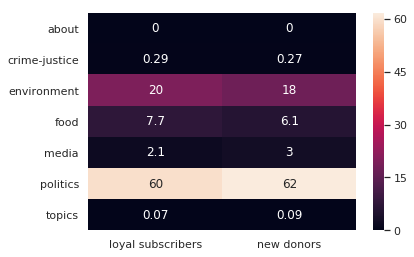

In [81]:
sns.heatmap(combo, annot=True)

In [86]:
print("Top 10 clicks from loyal subscribers")
find_most_popular_titles(df = click_data, emails = interested_groups['loyal subscribers'].index)

Top 10 clicks from loyal subscribers


,title,email_count,email_pct
85,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,66,20.89
149,whale-videos-triple-breach-wow,48,15.19
51,garrett-ventry-resign-kavanaugh,41,12.97
77,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,39,12.34
147,washington-carbon-ballot-i1631,38,12.03
137,trump-christine-blasey-ford-kavanaugh,37,11.71
91,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,37,11.71
127,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,36,11.39
70,jared-kushner-taxes-net-worth-real-estate-trump-investments,31,9.81
18,brian-wansink-the-cornell-professor-known-for-his-fun-food-research-retires-amid-scandal-1,29,9.18


In [87]:
print("Top 10 clicks from new donors")
find_most_popular_titles(df = click_data, emails = interested_groups['new donors'].index)

Top 10 clicks from new donors


,title,email_count,email_pct
101,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,147,25.43
152,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,111,19.20
63,garrett-ventry-resign-kavanaugh,101,17.47
180,whale-videos-triple-breach-wow,99,17.13
94,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,94,16.26
86,jared-kushner-taxes-net-worth-real-estate-trump-investments,90,15.57
164,trump-christine-blasey-ford-kavanaugh,80,13.84
177,washington-carbon-ballot-i1631,73,12.63
8,a-new-study-shows-how-mushrooms-could-save-bees-yes-mushrooms,72,12.46
99,midterm-elections-democrats-investigations,69,11.94


## Q6. Which behaviors are most likely to lead to subscription or donation?
only have oct campaign data. too little to analyze the factors that lead to donation or subscription

## Presentation summary
- donation:
    - regular donor
    - high-value donor
    - non donor
- subscription
    - print only
    - online only
    - both
    
- compare the six groups:
    - % print sub
    - % online click
    - avg urls
    - avg topics
    - avg donation
    - topic index vs avg online reader
    - top 10 articles vs avg online reader

In [99]:
nclicks_by_users = click_data.groupby('Email').agg({'Url': pd.Series.nunique,'topic':pd.Series.nunique})
nclicks_by_users = nclicks_by_users.reset_index()

nclicks_by_topics = reshape_data_to_wide(click_data,
                                         row = 'Email', 
                                         col = 'topic', 
                                         element = 'Url',
                                         cal = 'sum')
nclicks_by_topics = nclicks_by_topics.reset_index()
nclicks_by_topics = nclicks_by_topics.rename(columns = {'':'NA'})

sub_don_click_combined_temp = combine_dat_sets(combined, 
                                               nclicks_by_users, 
                                               'Email','Email', join_method = 'outer')
all_dat = combine_dat_sets(sub_don_click_combined_temp, 
                            nclicks_by_topics,
                             'Email','Email', join_method = 'outer')
all_dat = all_dat.set_index('Email')

In [143]:
def define_interested_groups(df):    
    
    """Take donation data and dive donors into different groups and save data in an ordered dictionary
    
    example 'df' is:
    sub_don_click_combined_filename = '/home/centos/mojo/subscription_donation_click_combined_data.pkl'
    df = pd.read_pickle(sub_don_click_combined_filename)
    """
    
    
    highvalue_donors = df.loc[df['don_total'] >= 500]
    regular_donors = df.loc[(df['don_total'] > 0) & (df['don_total'] < 500)]
    non_donors = df.loc[df['don_total'] == 0]
    
    sub_print_only = df.loc[(df['subs_freq'] >0) & (df['Url'] == 0)]
    sub_online_only = df.loc[(df['subs_freq'] == 0) & (df['Url'] > 0)]
    sub_both = df.loc[(df['subs_freq'] >0) & (df['Url']>0)]
    sub_all_online = df.loc[(df['Url']>0)]
    
    interested_groups=OrderedDict()
    interested_groups['regular donors (< $500)']=regular_donors
    interested_groups['highvalue donors (>= $500)']=highvalue_donors
    interested_groups['non donors']=non_donors
    interested_groups['print subscriber only'] = sub_print_only
    interested_groups['online reader only'] = sub_online_only 
    interested_groups['both print subscriber and online reader'] = sub_both
    interested_groups['all online readers'] = sub_all_online
    return interested_groups

In [144]:
interested_groups = define_interested_groups(df= all_dat)

### compare magazine subscription rate and newsletter click rate by each donor group 

In [109]:
# subscription rate summary
subscription_rate_summary = []

for grpname, dat in interested_groups.items():
    
    subscription_rate_summary.append(check_subscription_rate(df =dat, groupname =grpname))
    
subscription_rate_summary

subscription_rate_summary_df = pd.DataFrame.from_records(subscription_rate_summary)
subscription_rate_summary_df = subscription_rate_summary_df.rename(columns = {0:'group name',
                                                                    1: 'magazine subscription rate',
                                                                    2: 'newsletter click rate'})

print("compare magazine subscription rate and newsletter click rate by each donor group ")   
subscription_rate_summary_df

compare magazine subscription rate and newsletter click rate by each donor group 


,group name,magazine subscription rate,newsletter click rate
0,regular donors (< $500),25.12,14.78
1,highvalue donors (>= $500),22.24,18.44
2,non donors,47.14,55.88
3,print subscriber only,100.00,0.00
4,online reader only,0.00,100.00
5,both print subscriber and online reader,100.00,100.00


### compare avg number of clicks by each donor group

In [124]:
click_summary = []

for grpname, dat in interested_groups.items():
    
    click_summary.append(check_click_distribution(df =dat, groupname =grpname))
    
print("compare # urls clicked by each donor group ")    
pd.concat(click_summary, axis=1)


compare # urls clicked by each donor group 


,regular donors (< $500),highvalue donors (>= $500),non donors,print subscriber only,online reader only,both print subscriber and online reader
count,5313.00,97.00,49829.00,0.0,51045.00,4194.00
mean,6.45,7.02,4.22,NaN,4.38,5.13
std,10.00,8.70,9.54,NaN,9.70,8.37
min,1.00,1.00,1.00,NaN,1.00,1.00
25%,2.00,2.00,1.00,NaN,1.00,1.00
50%,3.00,4.00,2.00,NaN,2.00,3.00
75%,8.00,8.00,4.00,NaN,4.00,6.00
max,238.00,42.00,296.00,NaN,296.00,242.00


### compare avg number of topics by each donor group

In [125]:
topics_summary = []

for grpname, dat in interested_groups.items():
    
    topics_summary.append(check_topics_distribution(df =dat, groupname =grpname))
    
print("compare # topics clicked by each donor group ")    
display(pd.concat(topics_summary, axis=1))

compare # topics clicked by each donor group 


,regular donors (< $500),highvalue donors (>= $500),non donors,print subscriber only,online reader only,both print subscriber and online reader
count,5313.00,97.00,49829.00,0.0,51045.00,4194.00
mean,2.14,2.24,1.71,NaN,1.73,1.93
std,1.21,1.27,1.03,NaN,1.05,1.12
min,1.00,1.00,1.00,NaN,1.00,1.00
25%,1.00,1.00,1.00,NaN,1.00,1.00
50%,2.00,2.00,1.00,NaN,1.00,2.00
75%,3.00,3.00,2.00,NaN,2.00,3.00
max,8.00,5.00,8.00,NaN,8.00,8.00


### compare avg donation by each donor group

In [192]:
def check_avg_donor_rate(df, groupname):
    
    if sum(df['don_total']>0) >0:
        avg_don = round(df['don_total'][df['don_total']>0].median(),2)
    else:
        avg_don = 0
    return (groupname, avg_don)
                    
avg_donation_summary = []

for grpname, dat in interested_groups.items():
    
    avg_donation_summary.append(check_avg_donor_rate(df =dat, groupname =grpname))

avg_donor_summary_df = pd.DataFrame.from_records(avg_donation_summary)
avg_donor_summary_df = avg_donor_summary_df.rename(columns = {0:'group name',
                                                                    1: 'avg donation'})

print("compare average donation amounts by each donor group ")   
avg_donor_summary_df

compare average donation amounts by each donor group 


,group name,avg donation
0,regular donors (< $500),50.0
1,highvalue donors (>= $500),600.0
2,non donors,0.0
3,print subscriber only,50.0
4,online reader only,50.0
5,both print subscriber and online reader,50.0
6,all online readers,50.0


### compare topic click rate and index by each donor group

In [172]:
topics = ['crime-justice','environment','food','media','politics']
comparison_groups = interested_groups.keys()
combo = pd.concat([sub_df_colsum(df = interested_groups[k],cols = topics, name = k) for k in comparison_groups],axis=1)

# convert to click percentage
for g in comparison_groups:
      combo[g] = round(combo[g]/sum(interested_groups[g]['All'])*100,2) 

# how much likely the group is to click a topic than average
combo_index = combo.copy()
for c in combo_index.columns:
    combo_index[c] = round((combo_index[c]/combo['all online readers'] - 1)*100,2)


,regular donors (< $500),highvalue donors (>= $500),non donors,print subscriber only,online reader only,both print subscriber and online reader,all online readers
crime-justice,15.38,69.23,0.00,NaN,0.00,11.54,0.0
environment,6.42,17.32,-0.50,NaN,-0.39,4.19,0.0
food,-5.42,4.49,0.46,NaN,0.00,0.62,0.0
media,15.60,40.80,-1.20,NaN,-0.40,4.80,0.0
politics,1.24,-4.05,-0.09,NaN,-0.09,0.90,0.0


[Text(0.5,0,'regular donors (< $500)'),
 Text(1.5,0,'highvalue donors (>= $500)'),
 Text(2.5,0,'non donors'),
 Text(3.5,0,'print subscriber only'),
 Text(4.5,0,'online reader only'),
 Text(5.5,0,'both print subscriber and online reader')]

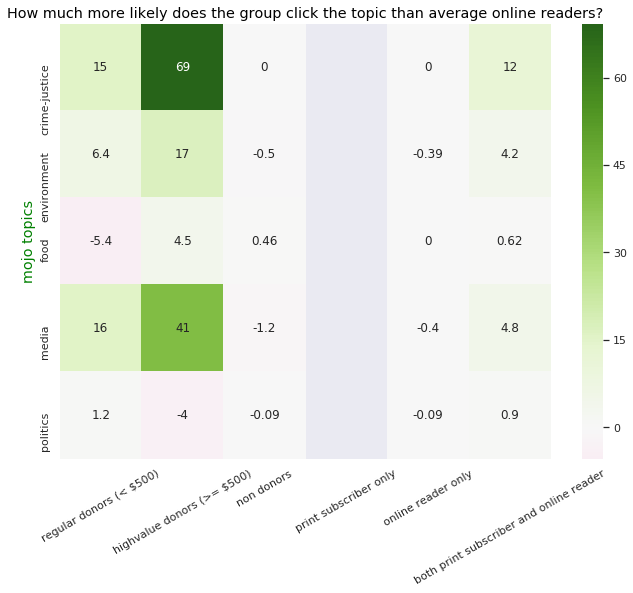

In [190]:
import seaborn as sns; sns.set()

sns.set(rc={'figure.figsize':(11,8)})
hm = sns.heatmap(combo_index.iloc[:,:6], annot=True,cmap="PiYG",center = 0)

hm.set_title('How much more likely does the group click the topic than average online readers?',fontsize = 'large', color = 'black')
hm.set_ylabel('mojo topics', fontsize = 'large', color = 'green')
hm.set_xticklabels(combo.columns, rotation=30)

[Text(0.5,0,'regular donors (< $500)'),
 Text(1.5,0,'highvalue donors (>= $500)'),
 Text(2.5,0,'non donors'),
 Text(3.5,0,'print subscriber only'),
 Text(4.5,0,'online reader only'),
 Text(5.5,0,'both print subscriber and online reader'),
 Text(6.5,0,'all online readers')]

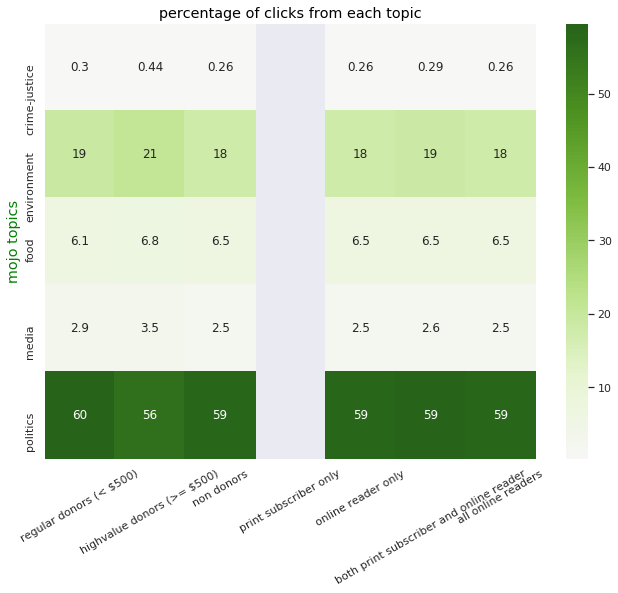

In [191]:
import seaborn as sns; 
sns.set(rc={'figure.figsize':(11,8)})
hm = sns.heatmap(combo, annot=True,cmap="PiYG", center = 0)

hm.set_title('percentage of clicks from each topic',fontsize = 'large', color = 'black')
hm.set_ylabel('mojo topics',fontsize = 'large', color = 'green')
hm.set_xticklabels(combo.columns, rotation=30)

### compare top clicks 

In [217]:
print("Top 10 clicks from loyal subscribers")
for k in interested_groups.keys():
    print(' #### {}'.format(k))
    display(find_most_popular_titles(df = click_data, emails = interested_groups[k].index)[['title','email_pct']])

Top 10 clicks from loyal subscribers
 #### regular donors (< $500)


,title,email_pct
114,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,0.253095
201,whale-videos-triple-breach-wow,0.210055
169,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,0.173872
70,garrett-ventry-resign-kavanaugh,0.170825
95,jared-kushner-taxes-net-worth-real-estate-trump-investments,0.152161
182,trump-christine-blasey-ford-kavanaugh,0.145306
198,washington-carbon-ballot-i1631,0.140164
105,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,0.138831
123,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,0.135784
9,a-new-study-shows-how-mushrooms-could-save-bees-yes-mushrooms,0.124929


 #### highvalue donors (>= $500)


,title,email_pct
65,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,0.273684
126,whale-videos-triple-breach-wow,0.263158
111,trump-christine-blasey-ford-kavanaugh,0.242105
61,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,0.210526
101,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,0.210526
86,senate-judiciary-committee-brett-kavanaugh-vote,0.210526
39,garrett-ventry-resign-kavanaugh,0.189474
70,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,0.157895
5,a-new-study-shows-how-mushrooms-could-save-bees-yes-mushrooms,0.157895
58,journalism-that-stands-for-something,0.147368


 #### non donors


,title,email_pct
118,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,0.202303
207,whale-videos-triple-breach-wow,0.141139
71,garrett-ventry-resign-kavanaugh,0.121505
98,jared-kushner-taxes-net-worth-real-estate-trump-investments,0.112747
174,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,0.108964
187,trump-christine-blasey-ford-kavanaugh,0.105572
108,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,0.102775
127,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,0.082463
204,washington-carbon-ballot-i1631,0.080325
29,brian-wansink-the-cornell-professor-known-for-his-fun-food-research-retires-amid-scandal-1,0.079975


 #### print subscriber only


,title,email_pct


 #### online reader only


,title,email_pct
118,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,0.205395
207,whale-videos-triple-breach-wow,0.146109
71,garrett-ventry-resign-kavanaugh,0.125191
98,jared-kushner-taxes-net-worth-real-estate-trump-investments,0.115483
174,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,0.113317
187,trump-christine-blasey-ford-kavanaugh,0.108785
108,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,0.105195
127,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,0.085640
204,washington-carbon-ballot-i1631,0.084116
29,brian-wansink-the-cornell-professor-known-for-his-fun-food-research-retires-amid-scandal-1,0.081729


 #### both print subscriber and online reader


,title,email_pct
114,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,0.231217
200,whale-videos-triple-breach-wow,0.171595
168,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,0.141299
70,garrett-ventry-resign-kavanaugh,0.141299
95,jared-kushner-taxes-net-worth-real-estate-trump-investments,0.130393
105,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,0.121910
181,trump-christine-blasey-ford-kavanaugh,0.120456
123,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,0.113669
197,washington-carbon-ballot-i1631,0.111730
28,brian-wansink-the-cornell-professor-known-for-his-fun-food-research-retires-amid-scandal-1,0.101794


 #### all online readers


,title,email_pct
118,more-brett-kavanaugh-classmates-are-saying-he-lied-to-congress,0.207369
207,whale-videos-triple-breach-wow,0.148057
71,garrett-ventry-resign-kavanaugh,0.126422
98,jared-kushner-taxes-net-worth-real-estate-trump-investments,0.116623
174,theres-one-big-thing-missing-from-this-campaign-ad-about-colin-kaepernick,0.115456
187,trump-christine-blasey-ford-kavanaugh,0.109677
108,lacroix-natural-beverage-corporation-lawsuit-natural-sparkling-water,0.106472
127,nirvana-unplugged-why-arent-more-americans-buying-electric-vehicles,0.087782
204,washington-carbon-ballot-i1631,0.086226
29,brian-wansink-the-cornell-professor-known-for-his-fun-food-research-retires-amid-scandal-1,0.083262
